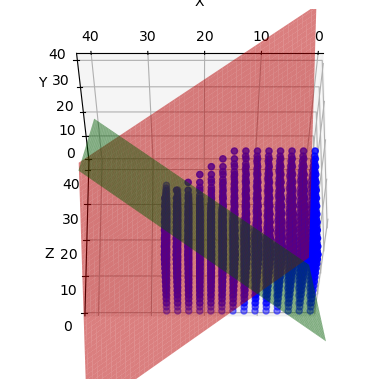

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ase import Atoms
from ase.build import make_supercell, sort
from ase.visualize import view
from ase.io import write

#This is 111 - 111 which needs to be rotated to propagate well

# Step 1: Create the NiO unit cell manually
a = 4.17  # Lattice constant for NiO
NiO = Atoms('Ni4O4',
            positions=[(0, 0, 0), (0.5*a, 0.5*a, 0), (0.5*a, 0, 0.5*a), (0, 0.5*a, 0.5*a),
                       (0.5*a, 0.5*a, 0.5*a), (a, 0.5*a, 0), (0.5*a, a, 0), (0, 0, 0.5*a)],
            cell=[a, a, a],
            pbc=True)

# Step 2: Create the supercell
supercell = make_supercell(NiO, np.diag([7,7,7]))

# Step 3: Define the (111) and (-1 1 1) planes for the V-shaped cut
def is_above_plane(pos, normal, d):
    return np.dot(pos, normal) > d

normal1 = np.array([1, 1, 1])
normal2 = np.array([-1, 1, 1])

# Intersection point should be around the center of the supercell
center_point = np.array(supercell.get_cell().diagonal()) / 2

# Introduce a shift for the center point
shift = np.array([1.0, 0.0, -1.0])  # Adjust this shift vector as needed
center_point_shifted = center_point + shift

# Calculate d1 and d2 so that the planes intersect at the shifted center point
d1 = np.dot(center_point_shifted, normal1)
d2 = np.dot(center_point_shifted, normal2)

# Step 4: Select atoms to delete for the V-shaped cut
indices_to_delete = []
for atom in supercell:
    pos = atom.position
    if is_above_plane(pos, normal1, d1) and is_above_plane(pos, normal2, d2):
        indices_to_delete.append(atom.index)

# Delete the selected atoms
del supercell[indices_to_delete]

# Step 5: Sort the atoms by type
supercell = sort(supercell)

# Step 6: Visualize the structure with planes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
positions = supercell.get_positions()

# Plot the atoms
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', marker='o')

# Define the planes
xx, yy = np.meshgrid(np.linspace(0, a*10, 100), np.linspace(0, a*10, 100))
z1 = (-normal1[0] * xx - normal1[1] * yy + d1) / normal1[2]
z2 = (-normal2[0] * xx - normal2[1] * yy + d2) / normal2[2]

# Plot the planes
ax.plot_surface(xx, yy, z1, alpha=0.5, color='r')
ax.plot_surface(xx, yy, z2, alpha=0.5, color='g')

# Set the view angle to look down the y-axis and rotate up 45 degrees
ax.view_init(elev=-25, azim=90)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0, a*10)
ax.set_ylim(0, a*10)
ax.set_zlim(0, a*10)
plt.show()

# View the resulting structure
#view(supercell)

# Save the modified structure as POSCAR
write('POSCAR', supercell, format='vasp')

# Save the modified structure as XSF
write('NiO_wedge_111.xsf', supercell, format='xsf')

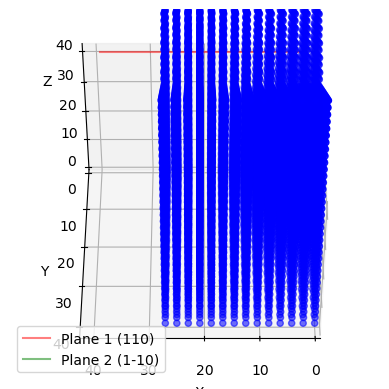

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ase import Atoms
from ase.build import make_supercell, sort
from ase.visualize import view
from ase.io import write, read

#110 case
# Step 1: Create the NiO unit cell manually
a = 4.17  # Lattice constant for NiO
NiO = Atoms('Ni4O4',
            positions=[(0, 0, 0), (0.5*a, 0.5*a, 0), (0.5*a, 0, 0.5*a), (0, 0.5*a, 0.5*a),
                       (0.5*a, 0.5*a, 0.5*a), (a, 0.5*a, 0), (0.5*a, a, 0), (0, 0, 0.5*a)],
            cell=[a, a, a],
            pbc=True)

# Step 2: Create the supercell
supercell = make_supercell(NiO, np.diag([30, 10, 7]))

# Step 3: Define the (110) and (1-10) planes for the V-shaped cut
def is_above_plane(pos, normal, d):
    return np.dot(pos, normal) > d

normal1 = np.array([0, -1, 1])
normal2 = np.array([0, 1, 1])

# Intersection point should be around the center of the supercell
center_point = np.array(supercell.get_cell().diagonal()) / 2

# Introduce a shift for the center point
shift = np.array([0.0, 0.0, -7.5])  # Adjust this shift vector as needed
center_point_shifted = center_point + shift

# Calculate d1 and d2 so that the planes intersect at the shifted center point
d1 = np.dot(center_point_shifted, normal1)
d2 = np.dot(center_point_shifted, normal2)

# Step 4: Select atoms to delete for the V-shaped cut
indices_to_delete = []
for atom in supercell:
    pos = atom.position
    if is_above_plane(pos, normal1, d1) and is_above_plane(pos, normal2, d2):
        indices_to_delete.append(atom.index)

# Delete the selected atoms
del supercell[indices_to_delete]

# Step 5: Sort the atoms by type
supercell = sort(supercell)

# Step 6: Assign charges
charges = {'Ni': 2.0, 'O': -2.0}
atom_charges = [charges[atom.symbol] for atom in supercell]

# Step 7: Write the LAMMPS data file with Ni atoms first, then O atoms
def write_lammps_data(filename, atoms, atom_charges):
    # Sort atoms by type (Ni first, then O)
    sorted_atoms = sorted(zip(atoms.get_positions(), atoms.get_chemical_symbols(), atom_charges), key=lambda x: (x[1], x[0].tolist()))

    num_atoms = len(atoms)
    num_atom_types = len(set(atoms.get_chemical_symbols()))

    cell = atoms.get_cell()
    positions, symbols, charges = zip(*sorted_atoms)

    with open(filename, 'w') as f:
        f.write("LAMMPS data file\n\n")
        f.write(f"{num_atoms} atoms\n")
        f.write(f"{num_atom_types} atom types\n\n")
        f.write(f"0.0 {cell[0,0]} xlo xhi\n")
        f.write(f"0.0 {cell[1,1]} ylo yhi\n")
        f.write(f"0.0 {cell[2,2]} zlo zhi\n\n")
        f.write("Masses\n\n")
        
        mass_dict = {'Ni': 58.6934, 'O': 15.999}  # Atomic masses
        type_dict = {'Ni': 1, 'O': 2}
        
        for symbol in ['Ni', 'O']:
            f.write(f"{type_dict[symbol]} {mass_dict[symbol]}\n")
        
        f.write("\nAtoms\n\n")
        
        for i, (pos, symbol, charge) in enumerate(zip(positions, symbols, charges)):
            type_id = type_dict[symbol]
            f.write(f"{i+1} 0 {type_id} {charge} {pos[0]} {pos[1]} {pos[2]}\n")

write_lammps_data('topology_output.lmp', supercell, atom_charges)

# View the resulting structure
#view(supercell)

# Save the modified structure as POSCAR
write('POSCAR', supercell, format='vasp')

# Save the modified structure as XSF
write('NiO_wedge_110.xsf', supercell, format='xsf')

In [4]:
#This is the test section since I dont want to screw up the above section
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ase import Atoms
from ase.build import make_supercell, sort
from ase.visualize import view
from ase.io import write, read

# Step 1: Create the NiO unit cell manually
a = 4.17  # Lattice constant for NiO
NiO = Atoms('Ni4O4',
            positions=[(0, 0, 0), (0.5*a, 0.5*a, 0), (0.5*a, 0, 0.5*a), (0, 0.5*a, 0.5*a),
                       (0.5*a, 0.5*a, 0.5*a), (a, 0.5*a, 0), (0.5*a, a, 0), (0, 0, 0.5*a)],
            cell=[a, a, a],
            pbc=True)

# Step 2: Create the supercell
supercell = make_supercell(NiO, np.diag([30, 10, 10]))

# Step 3: Define the (110) and (1-10) planes for the V-shaped cut
def is_above_plane(pos, normal, d):
    return np.dot(pos, normal) > d

normal1 = np.array([0, -1, 1])
normal2 = np.array([0, 1, 1])

# Intersection point should be around the center of the supercell
center_point = np.array(supercell.get_cell().diagonal()) / 2

# Introduce a shift for the center point
shift = np.array([0.0, 0.0, 5.0])  # Adjust this shift vector as needed
center_point_shifted = center_point + shift

# Calculate d1 and d2 so that the planes intersect at the shifted center point
d1 = np.dot(center_point_shifted, normal1)
d2 = np.dot(center_point_shifted, normal2)

# Step 4: Select atoms to delete for the V-shaped cut
indices_to_delete = []
for atom in supercell:
    pos = atom.position
    if is_above_plane(pos, normal1, d1) and is_above_plane(pos, normal2, d2):
        indices_to_delete.append(atom.index)

# Delete the selected atoms
del supercell[indices_to_delete]

# Step 5: Sort the atoms by type
supercell = sort(supercell)

# Step 6: Assign charges
charges = {'Ni': 2.0, 'O': -2.0}
atom_charges = [charges[atom.symbol] for atom in supercell]

# Step 7: Write the LAMMPS data file with Ni atoms first, then O atoms
def write_lammps_data(filename, atoms, atom_charges):
    # Sort atoms by type (Ni first, then O)
    sorted_atoms = sorted(zip(atoms.get_positions(), atoms.get_chemical_symbols(), atom_charges), key=lambda x: (x[1], x[0].tolist()))

    num_atoms = len(atoms)
    num_atom_types = len(set(atoms.get_chemical_symbols()))

    cell = atoms.get_cell()
    positions, symbols, charges = zip(*sorted_atoms)

    with open(filename, 'w') as f:
        f.write("LAMMPS data file\n\n")
        f.write(f"{num_atoms} atoms\n")
        f.write(f"{num_atom_types} atom types\n\n")
        f.write(f"0.0 {cell[0,0]} xlo xhi\n")
        f.write(f"0.0 {cell[1,1]} ylo yhi\n")
        f.write(f"0.0 {cell[2,2]} zlo zhi\n\n")
        f.write("Masses\n\n")
        
        mass_dict = {'Ni': 58.6934, 'O': 15.999}  # Atomic masses
        type_dict = {'Ni': 1, 'O': 2}
        
        for symbol in ['Ni', 'O']:
            f.write(f"{type_dict[symbol]} {mass_dict[symbol]}\n")
        
        f.write("\nAtoms\n\n")
        
        for i, (pos, symbol, charge) in enumerate(zip(positions, symbols, charges)):
            type_id = type_dict[symbol]
            f.write(f"{i+1} 0 {type_id} {charge} {pos[0]} {pos[1]} {pos[2]}\n")

write_lammps_data('topology_output.lmp', supercell, atom_charges)

# View the resulting structure
#view(supercell)

# Save the modified structure as POSCAR
write('POSCAR', supercell, format='vasp')

# Save the modified structure as XSF
write('NiO_wedge_110.xsf', supercell, format='xsf')

In [10]:
import numpy as np
from ase.io import read, write
from ase.visualize import view
from ase import Atom, Atoms

# Load the supercell structure and passivant structure
supercell = read('POSCAR')
passivant = read('ligand.xyz')

# Define the normals and distances for the planes
normal1 = np.array([0, -1, 1])
normal2 = np.array([0, 1, 1])
center_point = np.array(supercell.get_cell().diagonal()) / 2
shift = np.array([0.0, 0.0, -6.5])  # Adjust this shift vector as needed
center_point_shifted = center_point + shift
d1 = np.dot(center_point_shifted, normal1)
d2 = np.dot(center_point_shifted, normal2)

# Function to check if a position is within the wedge
def is_in_wedge(pos):
    return np.dot(pos, normal1) > d1 and np.dot(pos, normal2) > d2

# Define the region for the wedge
x_min, x_max = np.min(supercell.positions[:, 0]), np.max(supercell.positions[:, 0])
y_min, y_max = np.min(supercell.positions[:, 1]), np.max(supercell.positions[:, 1])
z_min, z_max = np.min(supercell.positions[:, 2]), np.max(supercell.positions[:, 2])

# Translate and add passivant atoms within the wedge
new_atoms = []
for atom in passivant:
    pos = atom.position
    for x_shift in np.arange(x_min, x_max, supercell.get_cell()[0,0]):
        for y_shift in np.arange(y_min, y_max, supercell.get_cell()[1,1]):
            for z_shift in np.arange(z_min, z_max, supercell.get_cell()[2,2]):
                new_pos = pos + np.array([x_shift, y_shift, z_shift])
                if is_in_wedge(new_pos):
                    new_atoms.append(Atom(symbol=atom.symbol, position=new_pos))

# Create an Atoms object from the new atoms
new_atoms_object = Atoms(new_atoms)

# Append the new atoms to the supercell
supercell += new_atoms_object

# Visualize the structure with passivant
view(supercell)

# Save the modified structure as POSCAR
write('POSCAR_with_passivant', supercell, format='vasp')

# Save the modified structure as XSF
write('NiO_wedge_with_passivant.xsf', supercell, format='xsf')